In [10]:
import argparse
import numpy as np
import pandas as pd
from time import time
from GraphTsetlinMachine.graphs import Graphs
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine

clauses=5000

def default_args(**kwargs):
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", default=1000, type=int)
    parser.add_argument("--number-of-clauses", default=clauses, type=int)
    #parser.add_argument("--number-of-state-bits", default=8, type=int)
    parser.add_argument("--T", default=clauses/1.6, type=int)
    parser.add_argument("--s", default=1.15, type=float)
    parser.add_argument("--depth", default=1, type=int)
    parser.add_argument("--hypervector-size", default=512, type=int)
    parser.add_argument("--hypervector-bits", default=2, type=int)
    parser.add_argument("--message-size", default=512, type=int)
    parser.add_argument("--message-bits", default=2, type=int)
    parser.add_argument('--double-hashing', dest='double_hashing', default=True, action='store_true')
    parser.add_argument("--number-of-examples", default=100000, type=int)
    parser.add_argument("--max-included-literals", default=64, type=int)

    args, unknown = parser.parse_known_args()
    for key, value in kwargs.items():
        if key in args.__dict__:
            setattr(args, key, value)
    return args

args = default_args()

In [11]:
dataset = pd.read_csv('8x8_5bf.csv')
dataset = dataset.head(args.number_of_examples)

board_size = 8

split_ratio = 0.9
split_index = int(len(dataset) * split_ratio)
train_dataset = dataset.iloc[:split_index]
test_dataset = dataset.iloc[split_index:]

X_train_board = train_dataset['board'].values
Y_train = train_dataset['winner'].values.astype(np.uint32)
X_test_board = test_dataset['board'].values
Y_test = test_dataset['winner'].values.astype(np.uint32)

cell_value_mapping = {
    0: 'Empty',
    1: 'Red',
    2: 'Blue'
}

edge_type_mapping = {
    0: 'Plain',
    1: 'Red',
    2: 'Blue',
    3: 'Corner'
}

def parse_board(board_string):
    game_state = {}
    board_string = board_string.replace(' ', '')
    for idx, symbol in enumerate(board_string):
        i = idx // board_size
        j = idx % board_size
        node_id = i * board_size + j
        if symbol == 'X':
            cell_value = 1
        elif symbol == 'O':
            cell_value = 2
        else:
            cell_value = 0
        game_state[node_id] = cell_value
    return game_state

train_games = [parse_board(board_string) for board_string in X_train_board]
test_games = [parse_board(board_string) for board_string in X_test_board]

train_graph_length = len(train_games)
test_graph_length = len(test_games)

edges = {}
for i in range(board_size):
    for j in range(board_size):
        node = (i, j)
        edges[node] = []

def addedge(node1, node2):
    if node2 not in edges[node1]:
        edges[node1].append(node2)

for i in range(board_size):
    for j in range(board_size):
        node = (i, j)

        if i < board_size - 1:
            addedge(node, (i + 1, j))
            addedge((i + 1, j), node)

            if j > 0:
                addedge(node, (i + 1, j - 1))
                addedge((i + 1, j - 1), node)

        if j < board_size - 1:
            addedge(node, (i, j + 1))
            addedge((i, j + 1), node)

        if i > 0:
            addedge(node, (i - 1, j))
            addedge((i - 1, j), node)

        if j > 0:
            addedge(node, (i, j - 1))
            addedge((i, j - 1), node)

node_indices = {}
index = 0
for i in range(board_size):
    for j in range(board_size):
        node = (i, j)
        node_indices[node] = index
        index += 1

In [12]:
print('Creating training data')

graphs_train = Graphs(
    train_graph_length,
    symbols=['Empty', 'Red', 'Blue', '1', '2', '3', '4', '5', 'connected',
             'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
             'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7','r8'],
    hypervector_size=args.hypervector_size,
    hypervector_bits=args.hypervector_bits,
)

for graph_id in range(train_graph_length):
    graphs_train.set_number_of_graph_nodes(graph_id, board_size ** 2)

graphs_train.prepare_node_configuration()

for graph_id in range(train_graph_length):
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            number_of_outgoing_edges = len(edges[node])
            graphs_train.add_graph_node(graph_id, node_id, number_of_outgoing_edges)

graphs_train.prepare_edge_configuration()

for graph_id in range(train_graph_length):
    game = train_games[graph_id]
    if graph_id % 10000 == 0:
        print('Adding edges for graph id:', graph_id)
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            cell_value = game.get(node_id, 0)
            edge_type = edge_type_mapping[0]

            for neighbor in edges[node]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    edge_type_value = edge_type_mapping.get(cell_value, 'Plain')
                    graphs_train.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type_value)
                else:
                    graphs_train.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type)

Y_train_labels = np.empty(train_graph_length, dtype=np.uint32)

for graph_id in range(train_graph_length):
    game = train_games[graph_id]
    Y_train_labels[graph_id] = Y_train[graph_id]

    if graph_id % 10000 == 0:
        print('Adding properties for graph id:', graph_id)

    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            cell_value = game.get(node_id, 0)
            cell_property = cell_value_mapping.get(cell_value)
            graphs_train.add_graph_node_property(graph_id, node_id, cell_property)

            num_neigh = 0
            for neighbor in edges[node]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    num_neigh += 1
            if num_neigh > 1:
                graphs_train.add_graph_node_property(graph_id, node_id, "connected")

            graphs_train.add_graph_node_property(graph_id, node_id, f"c{i+1}")
            graphs_train.add_graph_node_property(graph_id, node_id, f"r{j+1}")

graphs_train.encode()

Creating training data
Adding edges for graph id: 0
Adding edges for graph id: 10000
Adding edges for graph id: 20000
Adding edges for graph id: 30000
Adding edges for graph id: 40000
Adding edges for graph id: 50000
Adding edges for graph id: 60000
Adding edges for graph id: 70000
Adding edges for graph id: 80000
Adding properties for graph id: 0
Adding properties for graph id: 10000
Adding properties for graph id: 20000
Adding properties for graph id: 30000
Adding properties for graph id: 40000
Adding properties for graph id: 50000
Adding properties for graph id: 60000
Adding properties for graph id: 70000
Adding properties for graph id: 80000


In [13]:
# Test graph
print("Creating test data")
graphs_test = Graphs(test_graph_length, init_with=graphs_train)

for graph_id in range(test_graph_length):
    graphs_test.set_number_of_graph_nodes(graph_id, board_size ** 2)

graphs_test.prepare_node_configuration()

for graph_id in range(test_graph_length):
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            number_of_outgoing_edges = len(edges[node])
            graphs_test.add_graph_node(graph_id, node_id, number_of_outgoing_edges)

graphs_test.prepare_edge_configuration()

for graph_id in range(test_graph_length):
    game = test_games[graph_id]
    if graph_id % 1000 == 0:
        print('Adding edges for graph id:', graph_id)
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            cell_value = game.get(node_id, 0)
            edge_type = edge_type_mapping[0]

            for neighbor in edges[node]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    edge_type_value = edge_type_mapping.get(cell_value, 'Plain')
                    graphs_test.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type_value)
                else:
                    graphs_test.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type)

Y_test_labels = np.empty(test_graph_length, dtype=np.uint32)

for graph_id in range(test_graph_length):
    game = test_games[graph_id]
    Y_test_labels[graph_id] = Y_test[graph_id]

    if graph_id % 1000 == 0:
        print('Adding properties for graph id:', graph_id)

    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            cell_value = game.get(node_id, 0)
            cell_property = cell_value_mapping.get(cell_value)
            graphs_test.add_graph_node_property(graph_id, node_id, cell_property)

            num_neigh = 0
            for neighbor in edges[node]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    num_neigh += 1
            if num_neigh > 1:
                graphs_test.add_graph_node_property(graph_id, node_id, "connected")

            graphs_test.add_graph_node_property(graph_id, node_id, f"c{i+1}")
            graphs_test.add_graph_node_property(graph_id, node_id, f"r{j+1}")

graphs_test.encode()


Creating test data
Adding edges for graph id: 0
Adding edges for graph id: 1000
Adding edges for graph id: 2000
Adding edges for graph id: 3000
Adding edges for graph id: 4000
Adding edges for graph id: 5000
Adding edges for graph id: 6000
Adding edges for graph id: 7000
Adding edges for graph id: 8000
Adding edges for graph id: 9000
Adding properties for graph id: 0
Adding properties for graph id: 1000
Adding properties for graph id: 2000
Adding properties for graph id: 3000
Adding properties for graph id: 4000
Adding properties for graph id: 5000
Adding properties for graph id: 6000
Adding properties for graph id: 7000
Adding properties for graph id: 8000
Adding properties for graph id: 9000


In [14]:
train_acc = []
test_acc = []
epoch_list = []
epoch = 0


tm = MultiClassGraphTsetlinMachine(
    args.number_of_clauses,
    args.T,
    args.s,
    depth=args.depth,
    message_size=args.message_size,
    message_bits=args.message_bits,
    max_included_literals=args.max_included_literals,
    double_hashing = args.double_hashing,
    grid=(16*13,1,1),
    block=(128,1,1)
)

for i in range(args.epochs):
    epoch+=1
    start_training = time()
    tm.fit(graphs_train, Y_train, epochs=1, incremental=True)
    stop_training = time()

    start_testing = time()
    result_test = 100*(tm.predict(graphs_test) == Y_test).mean()
    stop_testing = time()

    result_train = 100*(tm.predict(graphs_train) == Y_train).mean()

    train_acc.append(result_train)
    test_acc.append(result_test)
    epoch_list.append(epoch)

    print(f"Epoch: {i}, Train acc: {result_train:.2f}, Test acc: {result_test:.2f}, Epoch time: {stop_testing-start_training:.2f}")

weights = tm.get_state()[1].reshape(2, -1)

print(graphs_test.hypervectors)
print(tm.hypervectors)
print(graphs_test.edge_type_id)


Initialization of sparse structure.
Epoch: 0, Train acc: 94.75, Test acc: 94.95, Epoch time: 33.79
Epoch: 1, Train acc: 98.12, Test acc: 98.23, Epoch time: 25.95
Epoch: 2, Train acc: 99.03, Test acc: 98.89, Epoch time: 23.19
Epoch: 3, Train acc: 99.35, Test acc: 99.29, Epoch time: 21.89
Epoch: 4, Train acc: 96.38, Test acc: 96.44, Epoch time: 21.13
Epoch: 5, Train acc: 98.63, Test acc: 98.66, Epoch time: 20.66
Epoch: 6, Train acc: 98.99, Test acc: 98.89, Epoch time: 19.86
Epoch: 7, Train acc: 99.31, Test acc: 99.18, Epoch time: 19.69
Epoch: 8, Train acc: 99.50, Test acc: 99.34, Epoch time: 19.42
Epoch: 9, Train acc: 99.33, Test acc: 99.21, Epoch time: 19.21
Epoch: 10, Train acc: 98.58, Test acc: 98.50, Epoch time: 19.14
Epoch: 11, Train acc: 99.66, Test acc: 99.57, Epoch time: 18.98
Epoch: 12, Train acc: 99.76, Test acc: 99.66, Epoch time: 19.02
Epoch: 13, Train acc: 98.76, Test acc: 98.80, Epoch time: 18.97
Epoch: 14, Train acc: 99.71, Test acc: 99.75, Epoch time: 19.31
Epoch: 15, Tra

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=10):
    return [np.mean(data[i:i+window_size]) for i in range(0, len(data), window_size)]

train_acc_smooth = moving_average(train_acc, window_size=10)
test_acc_smooth = moving_average(test_acc, window_size=10)

epoch_list_smooth = epoch_list[9::10]

plt.figure(figsize=(12, 6))

plt.plot(epoch_list_smooth, train_acc_smooth, label="Train accuracy", marker='o', linestyle='--')
plt.plot(epoch_list_smooth, test_acc_smooth, label="Test accuracy", marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for predictions of Hex game')

plt.legend(loc=5)

parameters_text = f"Board size: {board_size}x{board_size}\nDataset size: {len(dataset)}\nClauses: {args.number_of_clauses}\nT: {args.T}\ns: {args.s}\nDepth: {args.depth}\nHypervector Size: {args.hypervector_size}\nHypervector bits: {args.hypervector_bits}\nMessage Size: {args.message_size}\nMessage bits: {args.message_bits}\nLiterals: {args.max_included_literals}"
plt.text(0.91, 0.02, parameters_text, transform=plt.gca().transAxes, fontsize=10,
         ha='center', bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.savefig('hex_game_8x8-new5bf1.png')
plt.show()

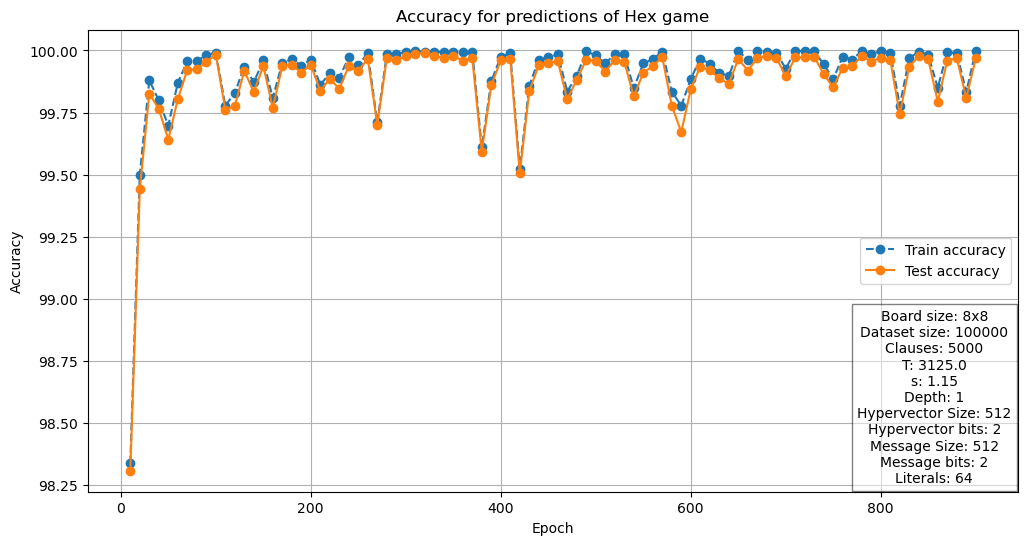

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Trim data to the first 500 epochs
max_epochs = 900
train_acc = train_acc[:max_epochs]
test_acc = test_acc[:max_epochs]
epoch_list = epoch_list[:max_epochs]

# Define moving average
def moving_average(data, window_size=10):
    return [np.mean(data[i:i+window_size]) for i in range(0, len(data) - window_size + 1, window_size)]

# Apply moving average
window_size = 10
train_acc_smooth = moving_average(train_acc, window_size=window_size)
test_acc_smooth = moving_average(test_acc, window_size=window_size)

# Generate corresponding epoch_list_smooth
epoch_list_smooth = epoch_list[window_size - 1::window_size]

# Plot
plt.figure(figsize=(12, 6))

plt.plot(epoch_list_smooth, train_acc_smooth, label="Train accuracy", marker='o', linestyle='--')
plt.plot(epoch_list_smooth, test_acc_smooth, label="Test accuracy", marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for predictions of Hex game')

plt.legend(loc=5)

parameters_text = f"Board size: {board_size}x{board_size}\nDataset size: {len(dataset)}\nClauses: {args.number_of_clauses}\nT: {args.T}\ns: {args.s}\nDepth: {args.depth}\nHypervector Size: {args.hypervector_size}\nHypervector bits: {args.hypervector_bits}\nMessage Size: {args.message_size}\nMessage bits: {args.message_bits}\nLiterals: {args.max_included_literals}"
plt.text(0.91, 0.02, parameters_text, transform=plt.gca().transAxes, fontsize=10,
         ha='center', bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.savefig('hex_game_8x8-new5bf1.png')
plt.show()
